In [1]:
from sklearn.datasets import load_digits       # Loading MNIST data using the function "load_digits" provided by sklearn package
import numpy as np                             # To use "SVD" function provided by numpy module
import matplotlib.pylab as plt                 # Matplot is a library to plot a graph
from sklearn.preprocessing import MinMaxScaler # Nomalizing the data
digits = load_digits()                         # Loading MNIST data: each digit has 8 by 8 dimension
data, label = digits.data, digits.target       # Seperate the data into two parts: data - its label

In [2]:
#############################################################################
# First: get the mean of the data set
mean = [np.mean(data[:,i]) for i in range (64)]
#############################################################################
# Second: get the principal components of all data
for i in range(64):
    normal = [(x - mean[i]) for x in data[:,i]]
    data[:, i] = normal
#############################################################################
K = 2  # Two principal components are used
U, S, V = np.linalg.svd(data)
X_rot = np.dot(U[:,:K], np.eye(K) * S[:K])

#############################################################################
# Normalizing the data 
scaler = MinMaxScaler()
# Fit and transform the data
X_rot = scaler.fit_transform(X_rot)

#############################################################################
# Currently we have 10 data sets (0, 1, ..., 9)
# We are going to use the two sets of numbers only which are specified in which_a and which_b
which_a  = 3
which_b  = 4
num_data = -1 # if all data is wanted, set it to -1
data_a = [[item[0], item[1]] for item, l in zip(X_rot, label) if l == which_a][0:num_data]
data_b  = [[item[0], item[1]] for item, l in zip(X_rot, label) if l == which_b][0:num_data]
train_features = np.array(data_a + data_b)
train_labels   = np.array([3]*len(data_a) + [4]*len(data_b))
# plt.plot(np.array(data_a)[:,0], np.array(data_a)[:,1], 'ro')
# plt.plot(np.array(data_b)[:,0], np.array(data_b)[:,1], 'b^')
print(f"Numbers {which_a} and {which_b} are chosen for classification.")
print(f"# of each data is {len(data_a)}.")

Numbers 3 and 4 are chosen for classification.
# of each data is 182.


In [3]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms import PegasosQSVC
from sklearn.svm import SVC
import time

algorithm_globals.random_seed = 12345

In [4]:
# TWO Quantum Kernel methods; one is QSVC and the other is PegasosQSVC
# which_kernel = 1: Quantum Kernel: PegasosQSVC: relatively fast (60+)
# which_kernel = 2: Quantum Kernel: QSVC:   quite slow (640+)
# which_kernel = 3: Quantum Kernel: QSVC (SVC+Qkernel): very slow (750+)
# which_kernel = 4: Classical Kernel: RBF: very fast ()

which_kernel = 1

# Record the start time
start_time = time.time()

if which_kernel == 1:
    num_qubits = 2
    tau = 100
    C = 1000
    feature_map  = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
    adhoc_kernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=adhoc_kernel, C=C, num_steps=tau)
    model        = pegasos_qsvc.fit(train_features, train_labels)
    print("PegasosQSVC running")
elif which_kernel == 2:
    adhoc_dimension = 2
    adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
    qsvc      = QSVC(quantum_kernel=adhoc_kernel)
    model     = qsvc.fit(train_features, train_labels)
    print("QSVC running")
elif which_kernel == 3:
    adhoc_dimension = 2
    adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
    adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
    model     = adhoc_svc.fit(train_features, train_labels)
    print("QSVC with callable function running")
else:
    adhoc_dimension = 2
    adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)            
    adhoc_svc = SVC(kernel='rbf', gamma=3000)
    model     = adhoc_svc.fit(train_features, train_labels)
    print("Classic SVC running with RBF Kernel")

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

PegasosQSVC running
Time taken: 0.5223855972290039 seconds


In [5]:
# Preparing to draw classified areas
h = 0.01
PC1 = np.array(train_features)[:, 0]
PC2 = np.array(train_features)[:, 1]
x_min, x_max = min(PC1) - 0.1, max(PC1) + 0.1
y_min, y_max = min(PC2) - 0.1, max(PC2) + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# To roughly check how long it will take
np.c_[xx.ravel(), yy.ravel()].shape

(11682, 2)

In [6]:
# Record the start time
start_time = time.time()

##################################################
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
##################################################

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 76.2612099647522 seconds


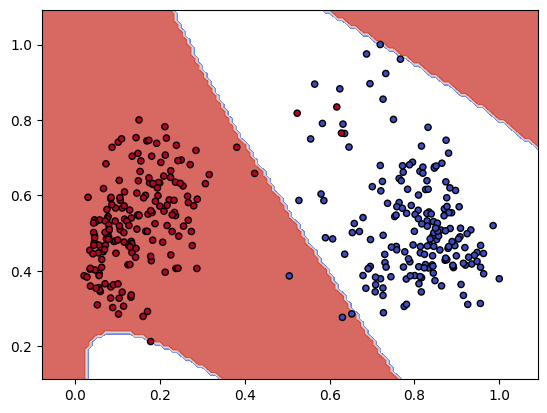

In [7]:
Z = Z.reshape(xx.shape)
out = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(PC1, PC2, c=train_labels, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.show()

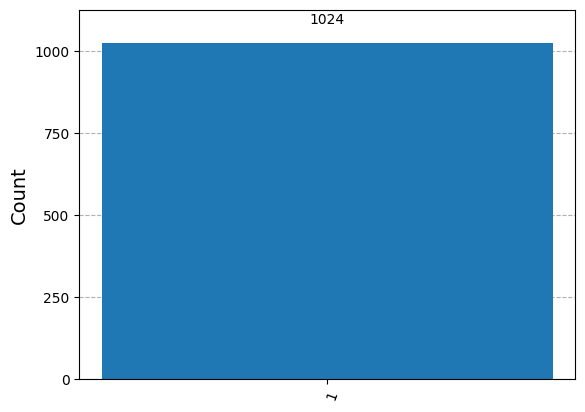

In [8]:
##################################################
# Quantum circuit creation for Deutsch algorithm
##################################################
# qiskit = 1.1.0
# qiskit-aer = 0.14.2
##################################################
from qiskit import *
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
# Number of quantum circuits
num_qc = 2
# Number of classical circuits
num_cc = 1
# Create a circuit object
qcircuit = QuantumCircuit(num_qc, num_cc)
# Add x gate to the quantum circuit (q_1)
qcircuit.x(1)
# Add Hadamard gate to the quantum circuits, (q_0) and (q_1), respectively
qcircuit.h(0)
qcircuit.h(1)
# Add CNOT gate which connects the quantum circuit from (q_0) to (q_1)
qcircuit.cx(0,1)
# Add Hadamard gate to the quantum circuit (q_0)
qcircuit.h(0)
# Measure the quantum circuit (q_0) and show the result in (C)
qcircuit.measure(0,0)
# Draw the quantum circuit which includes all the gates added
qcircuit.draw(output='mpl')
##################################################
# Run the circuit on a quantum simulator
##################################################
aer_sim = Aer.get_backend('aer_simulator')
t_qpe = transpile(qcircuit, aer_sim)
results = aer_sim.run(t_qpe, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)
